In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils
import utils

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

import importlib
import rt_filter_map_plot

from IPython.display import display, Markdown, Latex, HTML
import json

In [2]:
## parameters cell
itp_id = 87

In [3]:
# Parameters
district = "10 - Stockton"
itp_id = 349


In [4]:
airtable_organizations = (
    tbl.airtable.california_transit_organizations()
    >> select(_.itp_id, _.name, _.caltrans_district,
              _.website, _.ntp_id, _.drmt_organization_name)
    >> filter(_.itp_id == itp_id)
    >> collect()
)

In [5]:
# airtable_organizations

In [6]:
analysis_date = dt.date(2022, 6, 1) ##wednesday, new tables
## https://docs.google.com/spreadsheets/d/16tcL3fPdYkrNajDNneSR1b5ImhFOCJ0gWFnEaXyg16A/
if itp_id == 273: ##sacRT feed issue, again...
    analysis_date = dt.date(2022, 2, 8) ##tuesday for sacRT...

In [7]:
%%capture_parameters
human_date = analysis_date.strftime('%B %d (%A)')
human_date

In [8]:
%%capture
rt_day = rt_filter_map_plot.from_gcs(itp_id, analysis_date)

In [9]:
%%capture_parameters
agency_name = rt_day.calitp_agency_name
district = airtable_organizations.caltrans_district.iloc[0]
agency_name, district

# Turlock Transit

## About These Maps:

* Each map shows bus (and rail, if applicable) speeds for Turlock Transit, with a map each for the morning peak, midday, and afternoon peak periods on June 01 (Wednesday).
* On the map, routes are split into segments corresponding to the distance between two stops, allowing you to focus on specific portions of the route experiencing a slowdown.
* Route segments are arrow-shaped to indicate direction of travel.
* Hover over, or click, a segment with your mouse to see the exact speed, route name, and transit service frequency in that segment. 
    * Higher-frequency routes (3+ trips per hour) are especially important, since those slowdowns correspond to more vehicles, and riders, delayed in traffic.

In [10]:
## avoid papermill errors when map fails to render
m = None

## Morning Peak (6AM - 9AM)

In [11]:
%%capture
rt_day.set_filter(start_time='06:00', end_time='09:00')

In [12]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [13]:
m

In [14]:
rt_day.describe_slow_routes()

AM Peak slowest routes: 
 * 5, Lander, Southbound: 8.7 mph median trip speed for 6 trips
 * 4, Colorado, Eastbound: 9.6 mph median trip speed for 6 trips
 * 4, Colorado, Southbound: 9.6 mph median trip speed for 6 trips
 * 6, Soderquist, Southbound: 10.0 mph median trip speed for 6 trips
 * 2, Geer, Eastbound: 14.1 mph median trip speed for 1 trip
 * 6, Soderquist, Northbound: 14.1 mph median trip speed for 6 trips
 * 4, Colorado, Westbound: 15.8 mph median trip speed for 6 trips

## Midday (10AM - 2PM)

In [15]:
%%capture
rt_day.set_filter(start_time='10:00', end_time='14:00')

In [16]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [17]:
m

In [18]:
rt_day.describe_slow_routes()

Midday slowest routes: 
 * 5, Lander, Southbound: 6.7 mph median trip speed for 7 trips
 * 3, Olive, Eastbound: 6.8 mph median trip speed for 1 trip
 * 6, Soderquist, Southbound: 7.9 mph median trip speed for 7 trips
 * 4, Colorado, Southbound: 9.9 mph median trip speed for 3 trips
 * 4, Colorado, Eastbound: 9.9 mph median trip speed for 3 trips
 * 4, Colorado, Westbound: 12.3 mph median trip speed for 3 trips
 * 5, Lander, Northbound: 13.0 mph median trip speed for 7 trips

## Afternoon Peak (3PM - 7PM)

In [19]:
%%capture
rt_day.set_filter(start_time='15:00', end_time='19:00')

In [20]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [21]:
m

In [22]:
rt_day.describe_slow_routes()

PM Peak slowest routes: 
 * 5, Lander, Southbound: 7.3 mph median trip speed for 7 trips
 * 6, Soderquist, Southbound: 7.7 mph median trip speed for 7 trips
 * 4, Colorado, Eastbound: 9.5 mph median trip speed for 7 trips
 * 1, Countryside, Eastbound: 10.5 mph median trip speed for 2 trips
 * 4, Colorado, Westbound: 12.7 mph median trip speed for 7 trips
 * 6, Soderquist, Northbound: 14.3 mph median trip speed for 7 trips
 * 5, Lander, Northbound: 14.6 mph median trip speed for 7 trips

In [23]:
try:
    metrics_df = (rt_day.rt_trips
         >> group_by(_.route_short_name, _.direction_id)
         >> summarize(speed_variance = _.mean_speed_mph.var(),
                     mean_speed_mph = _.mean_speed_mph.mean(),
                     min_hour = _.median_time.min().hour,
                     max_hour = _.median_time.max().hour,
                     n = _.route_short_name.size)
         >> filter(_.min_hour <= 7, _.max_hour >= 15,
                   _.mean_speed_mph < _.mean_speed_mph.quantile(.6),
                   _.speed_variance, _.n > _.n.quantile(.4))
         >> arrange(-_.speed_variance)
         >> head(20)
        )
except Exception as e:
    pass
    # print(e)
## check that route has all-day span...

In [24]:
def map_from_metrics(rt_day, metrics_df):
    def show_title_and_map():
        try:
            am_map = rt_day.segment_speed_map(how='low_speeds', no_title = True)
            display(Markdown(f'20th Percentile Vehicle Speeds Between Stops{rt_day.filter_formatted}'))
            display(am_map)
        except Exception as e:
            display(Markdown(f'Map not available for this time/route'))
            pass
        return
    try:
        route_name = metrics_df.iloc[1,0]
        direction_id = metrics_df.iloc[1,1]
        # print(route_name, direction_id)
    except Exception as e:
        # print(e)
        return
    rt_day.set_filter(start_time='06:00', end_time='09:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()
    
    rt_day.set_filter(start_time='10:00', end_time='14:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()

    rt_day.set_filter(start_time='15:00', end_time='19:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()

    return

## Daily Speed Patterns

* This chart shows the distribution of median trip speeds throughout the day. It can help find times of day where transit riders experience the slowest overall speeds.

Median Trip Speed by Hour of Day, All Routes, 06:00–22:00, Jun 01 (Wed)

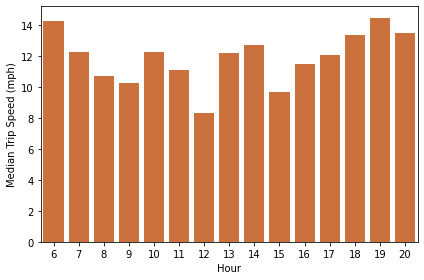

In [25]:
try:
    rt_day.set_filter(start_time='06:00', end_time='22:00')
    display(Markdown(f'Median Trip Speed by Hour of Day{rt_day.filter_formatted}'))

    # rt_day.chart_delays(no_title=True);
    rt_day.chart_speeds(no_title=True);
except:
    display(Markdown(f'Chart not available for this agency'))
    pass

## Single-Route Detail Example

* These maps highlight a single route which runs throughout the day, with a low average trip speed and a high amount of variation in speeds between different trips.

In [26]:
try:
    map_from_metrics(rt_day, metrics_df)
except Exception as e:
    # print(e)
    pass

20th Percentile Vehicle Speeds Between Stops, Route(s) 5, AM Peak, Jun 01 (Wed)

20th Percentile Vehicle Speeds Between Stops, Route(s) 5, Midday, Jun 01 (Wed)

20th Percentile Vehicle Speeds Between Stops, Route(s) 5, PM Peak, Jun 01 (Wed)

## Single Route Speed Variability

* This chart shows the _variability_ in speeds experienced by afternoon peak trips on the route mapped above. In this chart, each vertical strip corresponds to a segment of the map above. Within each strip, each dot represents the speed experienced in that segment by each trip in the afternoon peak. The segments are labelled by their end stop, generally a cross-street. Segments with high variability (some fast trips and some slow trips) might be better-suited to a different set of projects than segments that experience consistently slow speeds.

Speed Variablity by Stop Segment, Route(s) 5, PM Peak, Jun 01 (Wed)

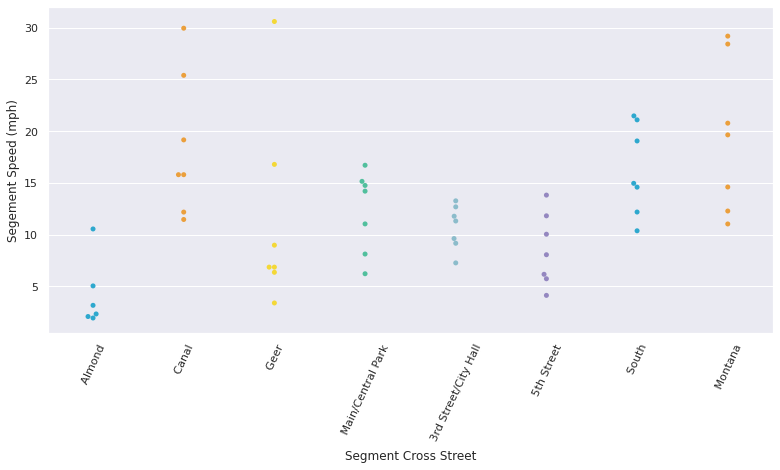

In [27]:
try:
    rt_day.filter['shape_ids'] = [(rt_day._filter(rt_day.rt_trips) >> count(_.shape_id)).shape_id.iloc[0]]

    display(Markdown(f'Speed Variablity by Stop Segment{rt_day.filter_formatted}'))

    ## filter to a max number of segments to display, split out title
    rt_day.chart_variability(num_segments=25, no_title=True);
except:
    display(Markdown(f'Chart not available for this agency'))
    pass